# Common Machine Learning and Deep Learning Methods for Clinical Text Classification
## Natural Language Processing for Healthcare Using NLTK, spaCy, Scikit-Learn, and Keras 

With the advance of machine learning and deep learning algorithms, Natural Language Processing (NLP) becomes a hot topic in both AI research and applications because text (e.g., English sentences) is a major type of natural language data. For example, text frequently appears in healthcare datasets such as Electronic Health Records (EHR). There are many AI methods for text data in healthcare domain such as Named Entity Recognition (NER) from clinical notes, clinical text classification, ..., etc. 

In this article I use an open source clinical text dataset to present some of the common machine learning and deep learning methods for clinical text classification.

Similarly to a normal machine learning process, a machine learning process for NLP consists of the following common steps:

* Data loading 
* Data Preprocessing
* Feature Engineering
* Model Selection
* Model training
* Model evaluation
* Model Deployment

In [1]:
# !pip install nltk
# !pip install keras
# !pip install tensorflow
# !pip install word2vec-keras
# !pip install scispacy # https://allenai.github.io/scispacy/
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.0/en_ner_bionlp13cg_md-0.5.0.tar.gz


In [2]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet'])
nltk.download('omw-1.4')
nltk.download('stopwords')
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sqlalchemy import create_engine

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

import numpy as np
import string 
# from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import gradient_descent_v2 
# from keras.optimizers import SGD # outdated
from tensorflow.keras.optimizers import RMSprop
from keras.initializers import VarianceScaling

import pickle

[nltk_data] Downloading package punkt to /Users/jadehuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jadehuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jadehuang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jadehuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
SEQUENCE_MODEL = False
MAX_TOKENS = 20000
MAX_LENGTH = 1500
USE_GROVE  = False

## 1. Data Loading

The way of loading a dataset is similar no matter whether or not the dataset contains text. As an example, the code below loads the open source clinical text classification dataset into memory as Pandas DataFrame:

In [4]:
data = pd.read_csv('./medical-nlp/data/mtsamples.csv', index_col=0)
print(data.shape)
data.head()

(4999, 5)


,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
data['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

## 2. Data Exploration



In [6]:
filtered_data = data[['transcription', 'medical_specialty']]
filtered_data.loc[:, 'medical_specialty'] = filtered_data['medical_specialty'].apply(lambda x:str.strip(x))
mask = (filtered_data['medical_specialty'] == 'SOAP / Chart / Progress Notes') | \
       (filtered_data['medical_specialty'] == 'Office Notes') | \
       (filtered_data['medical_specialty'] == 'Consult - History and Phy.') | \
       (filtered_data['medical_specialty'] == 'Emergency Room Reports') | \
       (filtered_data['medical_specialty'] == 'Discharge Summary') | \
       (filtered_data['medical_specialty'] == 'Letters') | \
       (filtered_data['medical_specialty'] == 'Pain Management')

filtered_data = filtered_data[~mask]

mask = filtered_data['medical_specialty'] == 'Neurosurgery'
filtered_data.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data['medical_specialty'] == 'Nephrology'
filtered_data.loc[mask, 'medical_specialty'] = 'Urology'

filtered_data['medical_specialty'].value_counts()

/Users/jadehuang/anaconda3/envs/mlenv/lib/python3.8/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Surgery                       1103
Cardiovascular / Pulmonary     372
Orthopedic                     355
Neurology                      317
Radiology                      273
General Medicine               259
Urology                        239
Gastroenterology               230
Obstetrics / Gynecology        160
ENT - Otolaryngology            98
Hematology - Oncology           90
Ophthalmology                   83
Pediatrics - Neonatal           70
Psychiatry / Psychology         53
Podiatry                        47
Dermatology                     29
Cosmetic / Plastic Surgery      27
Dentistry                       27
Physical Medicine - Rehab       21
Sleep Medicine                  20
Endocrinology                   19
Bariatrics                      18
IME-QME-Work Comp etc.          16
Chiropractic                    14
Rheumatology                    10
Diets and Nutritions            10
Speech - Language                9
Autopsy                          8
Lab Medicine - Patho

In [7]:
data_categories  = filtered_data.groupby(filtered_data['medical_specialty'])
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 100)
filtered_data_categories['medical_specialty'].value_counts()

Surgery                       1103
Cardiovascular / Pulmonary     372
Orthopedic                     355
Neurology                      317
Radiology                      273
General Medicine               259
Urology                        239
Gastroenterology               230
Obstetrics / Gynecology        160
Name: medical_specialty, dtype: int64

In [8]:
data = filtered_data_categories.sample(frac=1.0) # shuffling data to avoid artificial patterns
data.shape

(3308, 2)

## 2. Data Preprocessing

The major difference between a normal dataset and a NLP dataset is that the NLP dataset contains text features. A text feature consists of a list of sentences (called text or document corpus in NLP terminology). In terms of types of features, the difference is as follows:

There are two types of features in a normal dataset:
* numeric features (e.g., Temperature)
* categorical features (e.g., States such as 'IL', 'WA', etc.)

However there are three types of features in a dataset with NLP data:
* numeric feature (e.g., Temperature)
* categorical feature (e.g., the feature 'medical_specialty' as shown the above table)
* text feature (e.g., the feature 'transcription' in the above table)

In order to handle missing data, and reduce the size of vocabulary and training data, the following common data preprocessing steps are normally applied to a text feature (e.g., the transcription feature) for text classification:

* handle missing data
* standardize text
* tokenize text
* remove stopwords
* stemming
* lemmatize

### 2.1 Handle missing data
Missing data is not allowed in machine learning. Missing data can be simply dropped if the number of missing entries is relatively small. The other common method in handling missing data in NLP is to copy information from other related feature in the dataset. For example the missing entries in the NLP feature 'transcription' can be filled up by copying the corresponding entries from the feature 'description' because the description is a summary of the transcription.

In this article the missing entries in the feature transcription column are simply dropped without significantly compromise of model prediction accuracy because there are only 33 missing entries.

In [9]:
print('number of missing entries: ', data['transcription'].isna().sum())
df = data.dropna(subset=['transcription'])
df.shape

number of missing entries:  29


(3279, 2)

In [10]:
df.head()

,transcription,medical_specialty
1642,"HISTORY: , The patient is a 56-year-old right-...",Radiology
4670,"OPERATION: , Insertion of a #8 Shiley tracheos...",Cardiovascular / Pulmonary
1090,"PREOPERATIVE DIAGNOSIS:, Critical left caroti...",Surgery
3046,"CHIEF COMPLAINT:, Right hydronephrosis.,HISTO...",Urology
4805,"INDICATIONS: , An 82-year-old man entering the...",Cardiovascular / Pulmonary


### 2.2 Extract Medical Entities 

In [11]:
import spacy
import en_ner_bionlp13cg_md

nlp = en_ner_bionlp13cg_md.load()

def medical_entities( text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
    return ' '.join(entities)

df['transcription'] = df['transcription'].apply(medical_entities)

/var/folders/3x/wpkp7yvd54g0b670ln55y27h0000gp/T/ipykernel_11470/641765842.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transcription'] = df['transcription'].apply(medical_entities)


### 2.3 Standardize text
There are two common steps to standardize text:
* change text to lower case: this helps to avoid the effort for a machine learning model to learn the case of characters.
* remove punctuation: this helps to reduce the size of vocabulary

Given a text string, these two steps can be done in one statement as follows:

In [12]:
text = df['transcription'].values[0]
text

'patient female buttocks thigh left leg bowel bladder Medrol Dosepak spinal epidural extremities Straight leg lumbosacral spine lumbosacral paraspinal sensory distal F-waves extremities left tibial extremities lumbosacral paraspinal muscles lumbosacral paraspinal peroneus longus gastrocnemius medialis Left S1 nerve root peripheral neuropathy.,MRI lumbosacral spine L5-S1 patient spinal epidural injections'

In [13]:
# change to lower case and remove punctuation
text = text.lower().translate(str.maketrans('', '', string.punctuation))
text

'patient female buttocks thigh left leg bowel bladder medrol dosepak spinal epidural extremities straight leg lumbosacral spine lumbosacral paraspinal sensory distal fwaves extremities left tibial extremities lumbosacral paraspinal muscles lumbosacral paraspinal peroneus longus gastrocnemius medialis left s1 nerve root peripheral neuropathymri lumbosacral spine l5s1 patient spinal epidural injections'

### 2.4 Tokenize text

This helps to divide a text into elements of vocabulary. word-level (1-gram) tokenization is commonly used if text is treated as sequence of words. Word-level tokenization also enables the activities of removing stopwords, stemming, and lemmatization. 

N-gram ( typically N = 2 or 3) tokenization is usually used if text is treated as bag of words. 

As an example, the code below uses scikit-learn library to tokenize a text string into individual words/tokens.

In [14]:
from nltk.tokenize import word_tokenize

# divide string into individual words
tokens = word_tokenize(text)
tokens

['patient',
 'female',
 'buttocks',
 'thigh',
 'left',
 'leg',
 'bowel',
 'bladder',
 'medrol',
 'dosepak',
 'spinal',
 'epidural',
 'extremities',
 'straight',
 'leg',
 'lumbosacral',
 'spine',
 'lumbosacral',
 'paraspinal',
 'sensory',
 'distal',
 'fwaves',
 'extremities',
 'left',
 'tibial',
 'extremities',
 'lumbosacral',
 'paraspinal',
 'muscles',
 'lumbosacral',
 'paraspinal',
 'peroneus',
 'longus',
 'gastrocnemius',
 'medialis',
 'left',
 's1',
 'nerve',
 'root',
 'peripheral',
 'neuropathymri',
 'lumbosacral',
 'spine',
 'l5s1',
 'patient',
 'spinal',
 'epidural',
 'injections']

### 2.5 Remove Stopwords

this helps to reduce the size of vocabulary without compromise of model prediction accuracy. The following code uses the NLTK library to remove English stopwords from tokenized words.

In [15]:
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))

clean_tokens = []
for tok in tokens:
    tok = tok.strip() # remove space
    if tok not in english_stopwords:
        clean_tokens.append(tok)
        
clean_tokens

['patient',
 'female',
 'buttocks',
 'thigh',
 'left',
 'leg',
 'bowel',
 'bladder',
 'medrol',
 'dosepak',
 'spinal',
 'epidural',
 'extremities',
 'straight',
 'leg',
 'lumbosacral',
 'spine',
 'lumbosacral',
 'paraspinal',
 'sensory',
 'distal',
 'fwaves',
 'extremities',
 'left',
 'tibial',
 'extremities',
 'lumbosacral',
 'paraspinal',
 'muscles',
 'lumbosacral',
 'paraspinal',
 'peroneus',
 'longus',
 'gastrocnemius',
 'medialis',
 'left',
 's1',
 'nerve',
 'root',
 'peripheral',
 'neuropathymri',
 'lumbosacral',
 'spine',
 'l5s1',
 'patient',
 'spinal',
 'epidural',
 'injections']

### 2.6 stemming

This helps to reduce the size of vocabulary. The following code uses the NLTK library for stemming a word/token.

In [16]:
from nltk.stem import PorterStemmer

# create Stemmer object
stemmer = PorterStemmer()
stemming_word = stemmer.stem('being') # Stemming
stemming_word

'be'

### 2.7 Lemmatize

This helps to reduce the size of vocabulary. The code below uses the NLTK library to lemmatize a word/token.

In [17]:
from nltk.stem import WordNetLemmatizer

# change words to its root format
lemmatizer = WordNetLemmatizer()
root_word = lemmatizer.lemmatize('words') # lemmatizition
root_word

'word'

The data preprocessing steps above can be combined into one function to clean up a text string:

In [18]:
def clean_text(text):
    # get English stopwords
    english_stopwords = set(stopwords.words('english'))
    
    # change to lower case and remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # divide string into individual words
    tokens = word_tokenize(text)
    
    # create Stemmer object
    stemmer = PorterStemmer()
    
    # change words to its root format
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        tok = tok.strip() # remove space
        if tok not in english_stopwords:
            clean_tok = lemmatizer.lemmatize(tok) # lemmatizition
            clean_tok = stemmer.stem(clean_tok) # Stemming
            clean_tokens.append(clean_tok)

    return " ".join(clean_tokens) # combine tokens into one string when necessary

text = df['transcription'].values[0]
clean_tokens = clean_text(text)
clean_tokens

'patient femal buttock thigh left leg bowel bladder medrol dosepak spinal epidur extrem straight leg lumbosacr spine lumbosacr paraspin sensori distal fwave extrem left tibial extrem lumbosacr paraspin muscl lumbosacr paraspin peroneu longu gastrocnemiu mediali left s1 nerv root peripher neuropathymri lumbosacr spine l5s1 patient spinal epidur inject'

## 3. Feature Engineering

Once a text feature is preprocessed, each text (document) needs to be encoded as a vector of numbers (called vectorization) since machine learning and deep learning models only understand numbers. The selection of encoding method depends on how text is interpreted. In text classification, a text string (document) is typically treated as either a bag of words or a sequence of words. The following are some of the common text encoding/vectorization methods.

If a text is treated as bag of words, we can use the methods below to convert a text as one vector of numbers:
* TF-IDF vetorization
* Multi-Hot encoding

### 3.1 TF-IDF Vcetorization
The Multi-Hot encoding method encodes one text/document as a sparse vector of the length of vocabulary with the values of the 0's and 1's, which 1's indicate the presence of the corresponding words/tokens in the vocabulary.

Similarly to Multi-Hot, the TF-IDF vetorization also encodes one text as a sparse vector of the length of vocabulary. The major difference is that TF-IDF encoded vector records not only the presence information of the corresponding words/tokens in the vocabulary but also the token frequency (TF) weighted by the inverted document frequency (IDF). Because of this, TF-IDF encoded vector has more prediction power then Muti-Hot encoding.

The following code shows how to use TF-IDF to encode a given text string as one sparse vector:

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF encoding
text_array = df['transcription'].values[0:1]
tfidf = TfidfVectorizer(tokenizer=clean_text, ngram_range=(1,3))
tfidf_encoded_text = tfidf.fit_transform(text_array)
tfidf_encoded_text.todense()

matrix([[0.46167266, 0.02946847, 0.00982282, 0.00982282, 0.00982282,
         0.01964565, 0.00982282, 0.00982282, 0.04911411, 0.01964565,
         0.02946847, 0.01964565, 0.00982282, 0.00982282, 0.00982282,
         0.00982282, 0.00982282, 0.00982282, 0.11787387, 0.00982282,
         0.04911411, 0.00982282, 0.04911411, 0.02946847, 0.01964565,
         0.00982282, 0.01964565, 0.01964565, 0.05893694, 0.03929129,
         0.01964565, 0.00982282, 0.00982282, 0.06875976, 0.00982282,
         0.00982282, 0.03929129, 0.00982282, 0.01964565, 0.00982282,
         0.00982282, 0.01964565, 0.01964565, 0.00982282, 0.00982282,
         0.00982282, 0.00982282, 0.00982282, 0.24557056, 0.04911411,
         0.04911411, 0.00982282, 0.00982282, 0.00982282, 0.00982282,
         0.00982282, 0.00982282, 0.05893694, 0.04911411, 0.00982282,
         0.02946847, 0.02946847, 0.03929129, 0.02946847, 0.00982282,
         0.02946847, 0.00982282, 0.01964565, 0.00982282, 0.00982282,
         0.0884054 , 0.00982282, 0

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

def tfidf_pca(X_feature, y_label):
    '''
    X_feature = df['transcription'].values
    y_label = df['medical_specialty'].values
    '''
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_label)

    tfidf = TfidfVectorizer(tokenizer=clean_text, ngram_range=(1,3))
    pca = PCA(n_components=0.95)
    X_tfidf = tfidf.fit_transform(X_feature)
    X_pca = pca.fit_transform(X_tfidf.toarray())

    smote_over_sample = SMOTE(sampling_strategy='minority')

    X, y = smote_over_sample.fit_resample(X_pca, y_int.tolist())

    X = np.array(X)
    y = np.array(y)
    
    return X, y

### 3.2 Word Embedding

If a text is treated as a sequence of words, we can use the following common methods to convert each word in a text as one vector and the whole text as an array of vectors:
* One-Hot Encoding: encode each word as a sparse vector of the length of vocabulary (typically tens or hundreds of thousands).
* Word Embedding: encode each word as a dense vector of much shorter length (typically 250, 500, or 1,000) 

In addition to shorter length, the other big advantage of word embedding over one-hot encoding is that word embedding encodes the meaning of the word in such a way so that the words that are closer in the vector space are  similar in meaning. 

Given a text/document, there are two steps to map it to a dense vector of a given size:
* Step 1: convert the text into a vector of word/token indicies in the vocabulary
* Step 2: use a custom trained or pre-trained word embedding algorithm (e.g., Word2Vec and GloVe) to convert each word index into a dense vector of float numbers

The following code shows how to convert a text into a vector of word/token indicies in the vocabulary.

In [21]:
from tensorflow.keras import layers

def indecies_vectorize(X_feature, y_label, max_length = 1500, max_tokens = MAX_TOKENS):
    '''
    X_feature: df['transcription'].values
    max_length: maximum number of words in one text/document
    max_tokens: the length of vocabulary
    '''
    
    le = LabelEncoder()
    y_int = le.fit_transform(y_label)
    
    text_vectorization = layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_length,
    )

    # training the text vectorization object
    text_vectorization.adapt(X_feature) 
    # convert preprocessed training text into anrray of integers/indecies
    indecies_array = text_vectorization(X_feature) 
    
    smote_over_sample = SMOTE(sampling_strategy='minority')
    X, y = smote_over_sample.fit_resample(indecies_array, y_int)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

The code below shows how to use a custom trained word embedding layer from Keras to encode a vector of word indices as a sequence of dense vectors of length 250.

In [22]:
import keras

# create input layer
inputs = keras.Input(shape=(None,), dtype="int64")

# add word embedding layer
embedded = layers.Embedding(input_dim=MAX_TOKENS, output_dim=256, mask_zero=True)(inputs)

2022-03-15 22:21:06.123542: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 3.3 Positional Embedding 



In [23]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

The table below is a summary of the selections of different text encoding methods.

| Text Treatment Methods| Text Encoding Methods|
|:---|:---|
|Bag of Words |TF-IDF |
|Bag of Words|Multi-Hot |
|Sequence of Words |One-Hot |
|Sequence of Words |Word Embedding |
|Sequence of Words |Positional Embedding |

## 4. Model Selection

Similarly to the selection of text encoding methods, the selection of a machine learning or deep learning model for text classification depends on how text is encoded. Specifically, we can select a model as shown in the table below:

|Text Encoding Methods |Machine Learning or Deep Learning Models |
|:---|:---|
|TF-IDF |Any non-sequence classification model such as Logistic Regression, XGBoost, Random Forest, MLP, etc. |
|Multi-Hot |Any non-sequence classification model such as Logistic Regression, XGBoost, Random Forest, MLP, etc. |
|Word Embedding |Any sequence classification model such as LSTM, GRU, etc. |
|One-Hot Encoding |Any sequence classification model such as LSTM, GRU, etc. |
|Positional Embedding |Transformer |

The TransformerEncoder class below implements an attention-based transformer for clinical text classification in this article.

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


## 5. Model Training

Typically we need to split the dataset into training, validation, and testing subsets before model training begins. For simplicity, the dataset is only split into two subsets in this article: one for model training and the other for model testing/evaluation.  

In [25]:
from sklearn.model_selection import train_test_split

X_feature = df['transcription'].values
y_label = df['medical_specialty'].values

if SEQUENCE_MODEL:
    X, y = indecies_vectorize(X_feature, y_label)
else:   
    X, y = tfidf_pca(X_feature, y_label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3159, 845), (1053, 845), (3159,), (1053,))

### 5.1 Non-Sequence Modeling with TF-IDF

In this article I use Random Forest with TF-IDF encoding to demonstrate how to perform non-sequence modeling for text classification (see the code below).

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

if not SEQUENCE_MODEL:
    rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10)
    rf_clf.fit(X_train, y_train)


In [27]:
from sklearn.linear_model import LogisticRegression

if not SEQUENCE_MODEL:
    logistic_clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1)
    logistic_clf.fit(X_train, y_train)


In [28]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

if not SEQUENCE_MODEL:
    multi_class_clf = MultiOutputClassifier(KNeighborsClassifier())
    y_train = y_train.reshape(-1, 1)
    multi_class_clf.fit(X_train, y_train)


### 5.2 Sequence Modeling Using LSTM with Word Embedding

In this article I use LSTM with custom word embedding to demonstrate how to perform sequence modeling for text classification (see code below).

In [29]:
import numpy as np
path_to_glove_file = "./data/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [30]:
embedding_dim = 100

text_vectorization = layers.TextVectorization(
        max_tokens=MAX_TOKENS,
        output_mode="int",
        output_sequence_length=MAX_LENGTH,
    )

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((MAX_TOKENS, embedding_dim))
for word, i in word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [31]:
embedding_layer = layers.Embedding(
    MAX_TOKENS,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [32]:
import keras

def create_lstm_model(embedding_layer = None):
    # create input layer
    inputs = keras.Input(shape=(None,), dtype="int64")

    # add word embedding layer
    if embedding_layer is not None:
        embedded = embedding_layer(inputs)
    else:
        embedded = layers.Embedding(input_dim=MAX_TOKENS, output_dim=256, mask_zero=True)(inputs)

    # add LSTM layer
    x = layers.Bidirectional(layers.LSTM(32))(embedded)

    # add dropout layer
    x = layers.Dropout(0.5)(x)

    # add output layer
    outputs = layers.Dense(9, activation="softmax")(x)

    # combine all layers into one model
    lstm_model = keras.Model(inputs, outputs)

    # specifiy optimizer, loss, and metrics for the model
    lstm_model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    # print the summay of the model architecture
    lstm_model.summary()
    
    return lstm_model


if SEQUENCE_MODEL:
    if USE_GROVE:
        lstm_model = create_lstm_model(embedding_layer)
    else:
        lstm_model = create_lstm_model()
    
    # define callback function
    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                        save_best_only=False)
    ]

    # train model
    lstm_model.fit(X_train, y_train, epochs=10, callbacks=callbacks)

### 5.3 Sequence Modeling with Transformer

Recently the attention-based Transformer algorithm becomes a preferred algorithm over LSTM for sequence modeling. The code below uses the Transformer algorithm with positional embedding for clinical text classification.

In [33]:
def create_transformer():

    vocab_size = 20000
    sequence_length = 1500
    embed_dim = 256
    num_heads = 2
    dense_dim = 32

    inputs = keras.Input(shape=(None,), dtype="int64")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(9, activation="softmax")(x)
    transformer_model = keras.Model(inputs, outputs)
    transformer_model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    transformer_model.summary()
    
    return transformer_model

if SEQUENCE_MODEL:
    transformer_model = create_transformer()

    callbacks = [
        keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                        save_best_only=False)
    ]

    transformer_model.fit(X_train, y_train, epochs=10, callbacks=callbacks)


## 6. Model Evaluation


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, y_pred, labels):
    cm = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_) 
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax)

### 6.1 Non-Sequence Model Evaluation

Accuracy score:  0.3342830009496676
F1 score:  0.2956840674010129


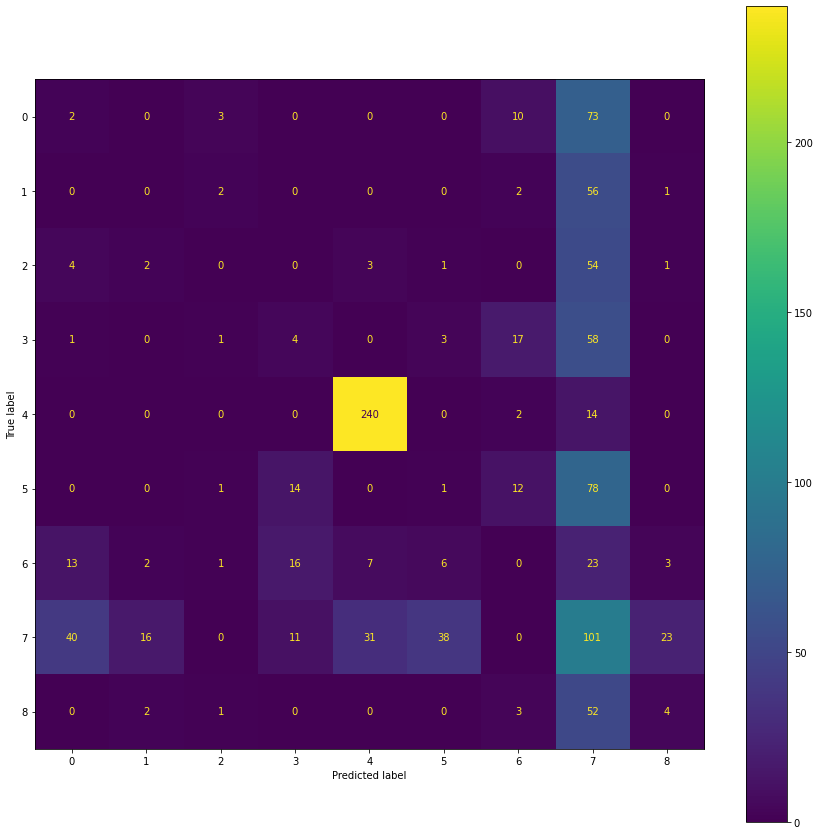

In [37]:
if not SEQUENCE_MODEL:
    y_pred = rf_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)

logistic_clf Accuracy score:  0.5669515669515669
logistic_clf F1 score:  0.544622616058455


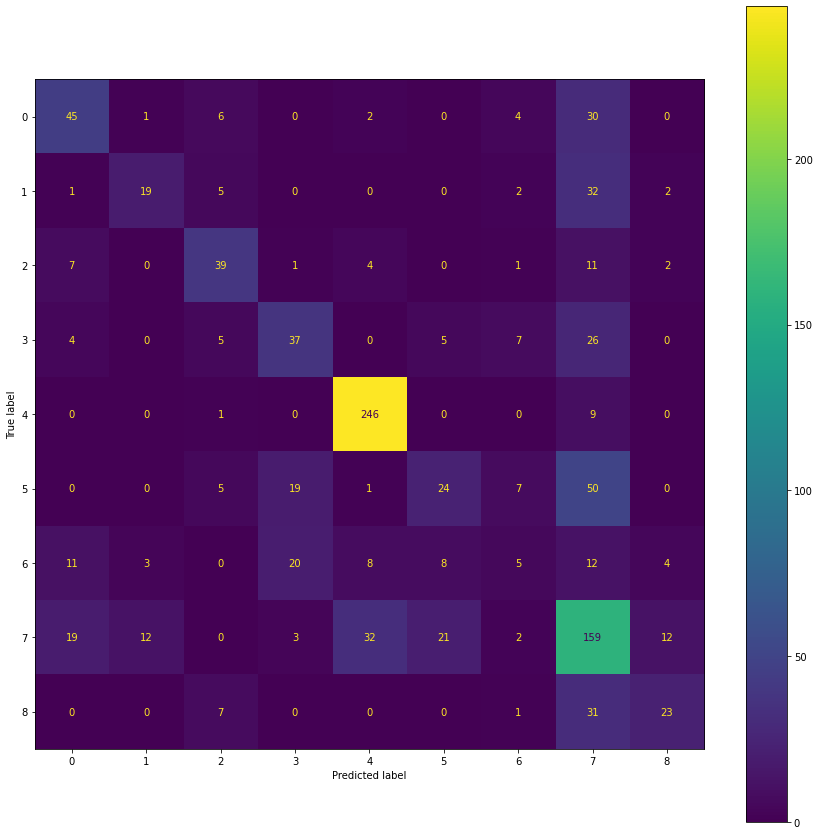

In [38]:
if not SEQUENCE_MODEL:
    y_pred = logistic_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('logistic_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('logistic_clf F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=logistic_clf.classes_)


multi_class_clf Accuracy score:  0.47293447293447294
multi_class_clf F1 score:  0.4332947562692282


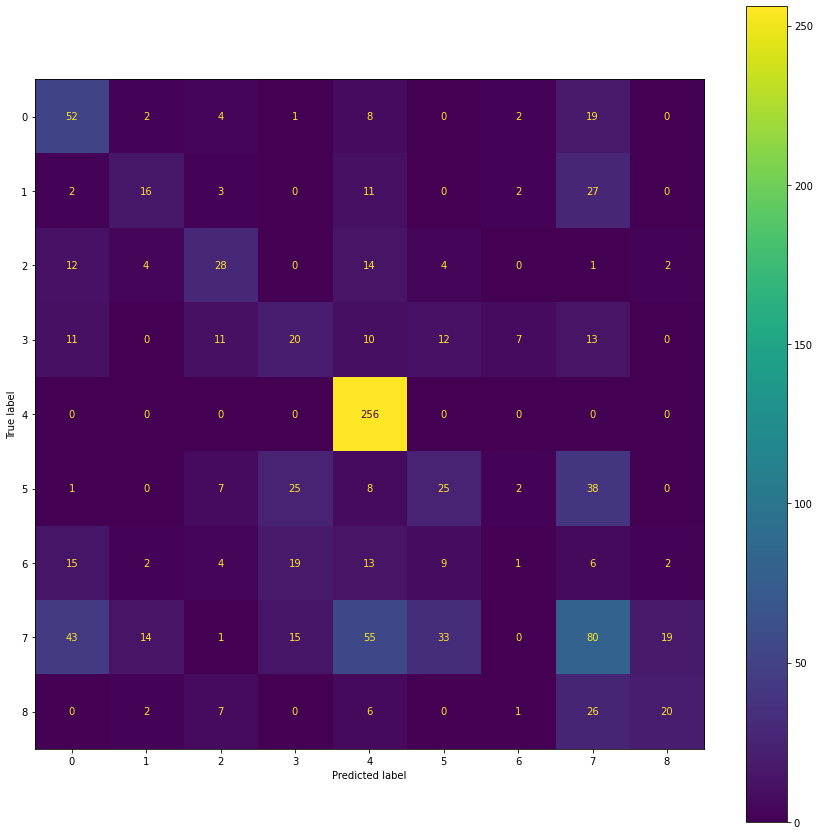

In [39]:
if not SEQUENCE_MODEL:
    y_test = y_test.reshape(-1, 1)

    y_pred = multi_class_clf.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)
    print('multi_class_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print('multi_class_clf F1 score: ', f1)
    
    plot_confusion_matrix(y_test, y_pred, labels=multi_class_clf.classes_)


### 6.2 Sequence Model Evaluation

In [ ]:
if SEQUENCE_MODEL:
    y_pred = lstm_model.predict(X_test)
    y_pred_labels = np.apply_along_axis(np.argmax, 1, y_pred) 

    acc_score = accuracy_score(y_test, y_pred_labels)
    print('lstm_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print('lstm_clf F1 score: ', f1)

In [ ]:
if SEQUENCE_MODEL:
    y_pred = transformer_model.predict(X_test)
    y_pred_labels = np.apply_along_axis(np.argmax, 1, y_pred) 

    acc_score = accuracy_score(y_test, y_pred_labels)
    print('transformer_clf Accuracy score: ', acc_score)

    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print('transformer_clf F1 score: ', f1)

### Summary of Model Evaluation Results

|Model |Accuracy |F1 Score |
|:---|:---|:---|
|Logistic Regression |0.581 |0.562 |
|Multi-Output Classifier |0.448 |0.410 |
|Random Forest |0.345 |0.307 |
|LSTM |0.432 |0.438 |
|Transformer |0.427 |0.427 |

## 7. Model Deployment

Once the best model for text classification has been identified for deployment in model evaluation, we can deploy the identified model into a production system. One common method is to deploy the model as a Web service on a server, which can be called by other components in a target production system to get text classification results.

To this end both the selected trained model (e.g., Random Forest) and the related encoding objects can be saved into Python pickle files after model training. These saved encoding objects and model can then be loaded back into memory for prediction in the deployment environment.

## 8. Conclusion

In this article I used an open source clitical text dataset to demonstrate some of the common text/document encoding methods and related machine learning and deep learning algorithms for clinical text classification. 

There are various types of text encoding methods and machine learning/deep learning algorithms. This article provided a summary of mapping between different text encoding methods and applicable machine learning/deep learning models. 

## References
[1] scispaCy: https://allenai.github.io/scispacy/

[2] Clinical Text Classification: https://www.kaggle.com/ritheshsreenivasan/clinical-text-classification